In [ ]:

!apt-get update -qq
!apt-get install -qq fonts-nanum* 


Selecting previously unselected package fonts-nanum-extra.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-extra_20180306-3_all.deb ...
Unpacking fonts-nanum-extra (20180306-3) ...
Selecting previously unselected package fonts-nanum.
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-2_all.deb ...
Unpacking fonts-nanum-coding (2.5-2) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Setting up fonts-nanum-extra (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Setting up fonts-nanum-coding (2.5-2) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


In [30]:
#크롤링시 필요한 라이브러리 불러오기
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)
    # 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)
def makeUrl(search,start_pg,end_pg):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&start=" + str(start_page)
        print("생성url: ",url)
        return url
    else:
        urls= []
        for i in range(start_pg,end_pg+1):
            page = makePgNum(i)
            url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&start=" + str(page)
            urls.append(url)
        print("생성url: ",urls)
        return urls
# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content
#뉴스기사 내용 크롤링하는 함수 만들기(각 뉴스의 url)
def news_contents_crawler(news_url):
    contents=[]
    for i in news_url:
        #각 기사 html get하기
        news = requests.get(i)
        news_html = BeautifulSoup(news.text,"html.parser")
            #기사 내용 가져오기 (p태그의 내용 모두 가져오기) 
        contents.append(news_html.find_all('p'))
    return contents
#html생성해서 기사크롤링하는 함수 만들기(제목,url): 3개의 값을 반환함(제목, 링크, 내용)
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(i)
    html = BeautifulSoup(original_html.text, "html.parser")
    # 검색결과
    articles = html.select("div.group_news > ul.list_news > li div.news_area > a")
    title = news_attrs_crawler(articles,'title')
    url = news_attrs_crawler(articles,'href')
    content = news_contents_crawler(url)
    return title, url, content #3개의 값을 반환
#뉴스크롤링 시작

#검색어 입력
#search = input("검색할 키워드를 입력해주세요:")
search = "산악 사고"
#검색 시작할 페이지 입력
#page = int(input("\n크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
page =1
print("\n크롤링할 시작 페이지: ",page,"페이지")   
#검색 종료할 페이지 입력
#page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
page2 =2
print("\n크롤링할 종료 페이지: ",page2,"페이지")   

# naver url 생성
url = makeUrl(search,page,page2)

#뉴스 크롤러 실행
news_titles = []
news_url =[]
news_contents =[]
for i in url:
    title, url,content = articles_crawler(url)
    news_titles.append(title)
    news_url.append(url)
    news_contents.append(content)
    
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 뉴스 내용을 하나의 텍스트로 합치기
all_text = ' '.join([' '.join([str(p) for p in content]) for content in news_contents])

print("검색된 기사 갯수: 총 ",(page2+1-page)*10,'개')
print("\n[뉴스 제목]")
print(news_titles)
print("\n[뉴스 링크]")
print(news_url)
print("\n[뉴스 내용]")
###print(news_contents)

import csv
output_file = "news.csv"

# 검색된 기사 갯수
total_articles = (page2 + 1 - page) * 10

# CSV 파일에 결과 저장
with open(output_file, "w", encoding="euc-kr", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["뉴스 제목", "뉴스 링크"])  # CSV 파일의 헤더 작성

    for i in range(len(news_titles)):
        for j in range(len(news_titles[i])):
            writer.writerow([news_titles[i][j], news_url[i][j]])  # 뉴스 제목과 링크를 CSV 파일에 추가

print("검색된 기사 갯수: 총", total_articles, "개")
print("결과가", output_file, "파일에 저장되었습니다.")


# 함수 추가: HTML 태그 제거
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# 뉴스 내용을 하나의 텍스트로 합치기
all_text = ' '.join([' '.join([remove_html_tags(str(p)) for p in content]) for content in news_contents])



크롤링할 시작 페이지:  1 페이지

크롤링할 종료 페이지:  2 페이지
생성url:  ['https://search.naver.com/search.naver?where=news&sm=tab_pge&query=산악 사고&start=1', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=산악 사고&start=11']
검색된 기사 갯수: 총  20 개

[뉴스 제목]
[['빗길 교통사고·설악산 조난…사건사고로 얼룩진 황금연휴', '인제군, 여름철 물놀이 사고 예방 총력…안전요원 60명 채용', '일가족 4명 일산화탄소 중독 등 연휴 강원도서 사고 잇따라', '남해소방서， 봄철 산악사고 임명구조 합동 훈련', '5월 마지막 연휴 맞아 관광 인파 몰린 강원도…사건사고도 속출', '다슬기 줍다, 등산하다, 캠핑하다… 연휴기간 강원도내 사고 속출', "고흥군, 산악·해안 지역 '국가지점 번호판' 일제조사 추진", '황금연휴 첫날 설악산 산악사고 잇따라… 2명 사상', '세계 최강용병 출신 산악인 두 다리 잃고 에베레스트 ‘의족 점령’', '설악산에서 산악사고 사망 1명, 부상자 구조 2건'], ["'황금연휴' 강원 등반사고 얼룩… 1명 사망 등 13명 구조", '고흥군, 산악·해안지역 국가지점번호판 일제조사', '진천소방서 산악구조훈련', '광주 서부소방서, 산악 구조 특별교육훈련 실시', '[굿모닝월드]세계 최장 코스, 산악자전거 다운힐 경주', '김해동부소방서, 산악사고 대비 인명구조 훈련', '지난해 오스트리아 산악 사망자 286명', '스위스 서부 산악지역서 관광용 비행기 추락…3명 사망', '봉화소방서, 산불·산악사고 예방 위한 메타버스 홍보관 개관', '등산 시 산악 위치표지판 미리 확인하세요']]

[뉴스 링크]
[['http://news.tvchosun.com/site/data/html_dir/2023/05/28/2023052890065.html', 'https://www.yna.co

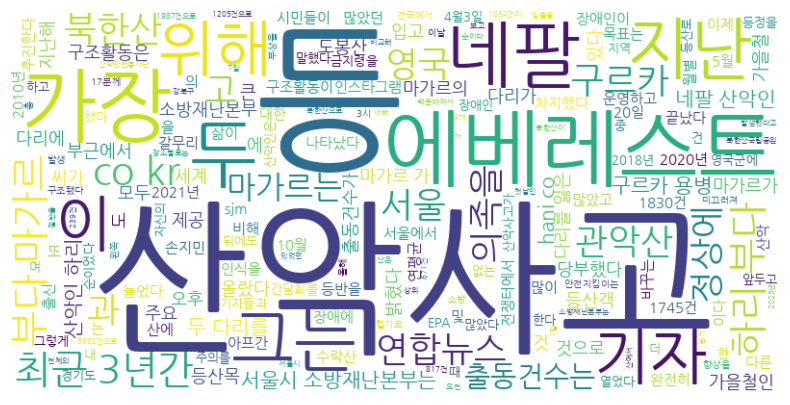

In [29]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def crawl_webpages(urls):
    titles = []

    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # 웹 페이지에서 필요한 데이터를 추출하는 코드 작성
        # 예시: 기사 제목 추출
        article_titles = soup.find('div', attrs={'class': 'text'})

        for title in article_titles:
            titles.append(title.text.strip())

    return titles

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 크롤링할 웹 페이지 URL 리스트
urls = [
    "https://www.hani.co.kr/arti/area/capital/1086968.html",
    "https://www.hani.co.kr/arti/international/international_general/1092729.html",
    "https://www.hani.co.kr/arti/area/capital/1060989.html?_ga=2.243351238.235351873.1685421754-1406187530.1685421754",
    "https://www.hani.co.kr/arti/area/capital/1060832.html?_ga=2.151179770.235351873.1685421754-1406187530.1685421754",
    "https://www.hani.co.kr/arti/society/society_general/244475.html?_ga=2.152206842.235351873.1685421754-1406187530.1685421754"

]

# 웹 페이지 크롤링
titles = crawl_webpages(urls)

# 크롤링한 데이터를 하나의 문자열로 변환
text_data = ' '.join(titles)

import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 설정
fontprop = fm.FontProperties(fname=font_path)

# 워드 클라우드 생성
generate_wordcloud(text_data)
